In [1]:
#Import the librarys
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings

In [45]:
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline

In [34]:
import colorlover as cl
bupu = cl.scales['9']['seq']['BuPu']
bupu500 = cl.interp( bupu, 20 )
pubu = cl.scales['5']['seq']['PuBu']

In [18]:
# Upload the Data
df = pd.read_csv('adult_train.csv')

In [19]:
# Brief overview on data
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,classe
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [20]:
# Shape of datase
df.shape

(48842, 15)

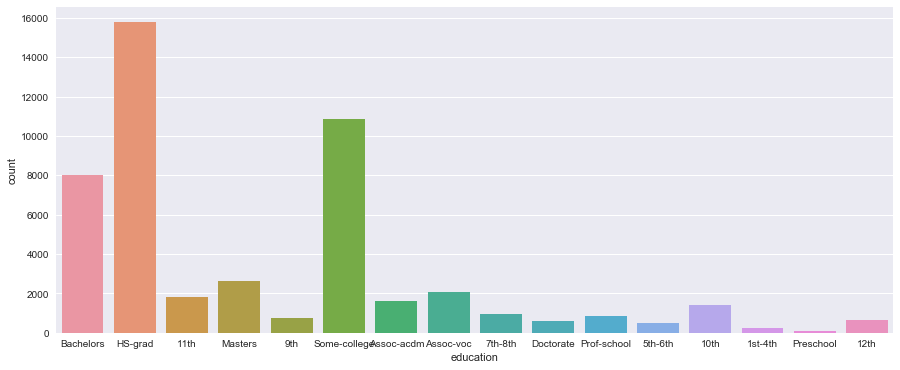

In [21]:
# Let's explore the features starting with education
plt.figure(figsize=(15,6))
sns.countplot(x='education', data=df)

In [22]:
# Simple PMF (getting the frequency by each category)
# Lets plot with plotly to get the real values by 'hovering' the bars.
trace1 = go.Bar(x=df['education'].value_counts().index.values,
                y=(df['education'].value_counts().values/len(df['education'])),
                name='Education PMF')
data = [trace1]
layout = go.Layout(title='Education Distribution PMF')
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='EmbDist')
                   

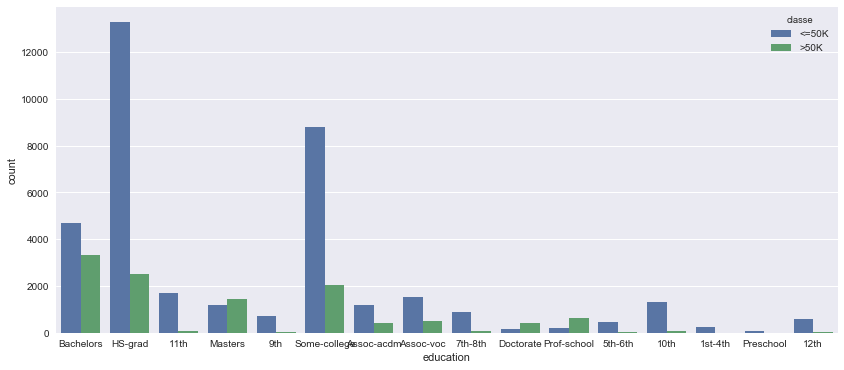

In [23]:
# Does education plays a role in the target variable? (Before testing, I believe it does.)
plt.figure(figsize=(14,6))
sns.countplot(x='education', data=df, hue='classe')

In [24]:
# We can see that undergrad people are likely to earn less than 50k
# But by this plot it's hard to know the likelihood, a better way is to get the mean of people who earn more and less than 50k
# First we need to transform the target class to binary (0,1)
df['classe'] = df['classe'].apply(lambda x: 0 if x == '<=50K' else 1)

In [38]:
education_classe_mean = df[['education','classe']].groupby(['education'],as_index=False).mean().sort_values(by='classe',ascending=True)

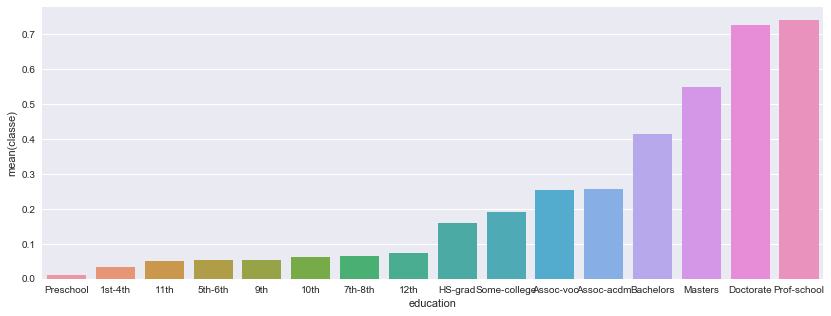

In [39]:
plt.figure(figsize=(14,5))
sns.barplot(x='education', y='classe', data=education_classe_mean)

In [40]:
data = [
    go.Bar(
    x=education_classe_mean['education'],
    y=education_classe_mean['classe'],    
    opacity=0.75,
        marker=dict(
        color=bupu500)
    )
]
layout = go.Layout(title='education Mean >50k$ Distribution')
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='EmbDist')

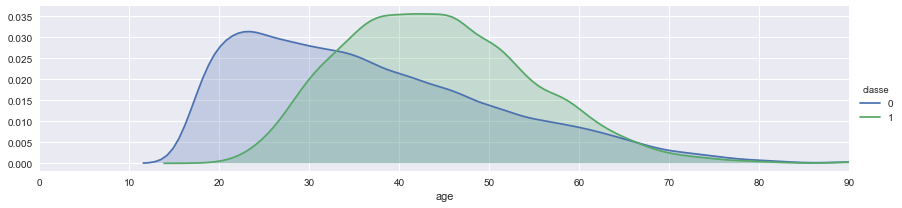

In [47]:
# Alright this plot describe well the level of education that earn more than 50K
# But we have too little prof-schoolers, docotares in this dataset, I'll consider merging some categorys latter.
# Lets Take a look at age
facet = sns.FacetGrid(df, hue="classe",aspect=4)
facet.map(sns.kdeplot,'age',shade= True)
facet.set(xlim=(0, df['age'].max()))
facet.add_legend()

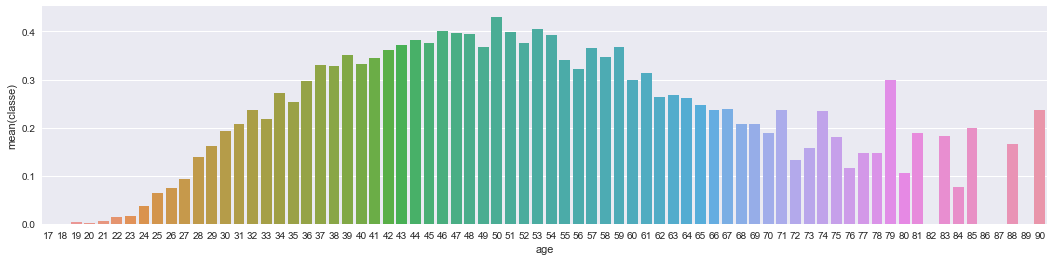

In [43]:
# People between 35 and 55 seems to earn more
# Lets check the mean of 50K> by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = df[["age", "classe"]].groupby(['age'],as_index=False).mean()
sns.barplot(x='age', y='classe', data=average_age)

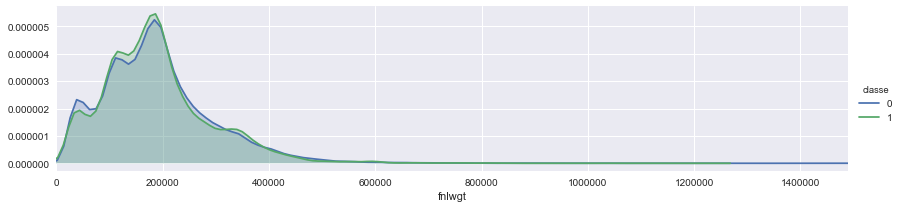

In [46]:
# As expected...  i'll consider removing some outliars
# Let's check fnlwgt
facet = sns.FacetGrid(df, hue="classe",aspect=4)
facet.map(sns.kdeplot,'fnlwgt',shade= True)
facet.set(xlim=(0, df['fnlwgt'].max()))
facet.add_legend()

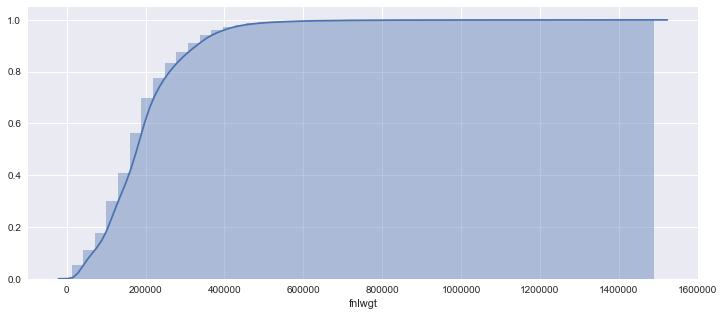

In [48]:
# Apparently fnlwgt doesn't play a role on the target column
# Lets take a look of the fnlwgt cumulative distribution
plt.figure(figsize=(12,5))
sns.distplot(df['fnlwgt'], hist_kws={'cumulative': True}, kde_kws={'cumulative': True})

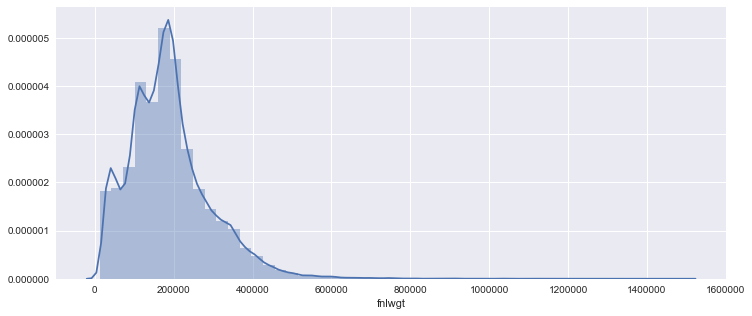

In [49]:
# Lets take a look of the fnlwgt distribution
plt.figure(figsize=(12,5))
sns.distplot(df['fnlwgt'])

In [52]:
# I'll consider some transformation on this feature, i need to take a look which distribution is this
# Let's take a look into another continuous feature
df['capital-gain'].describe()

count    48842.000000
mean      1079.067626
std       7452.019058
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64

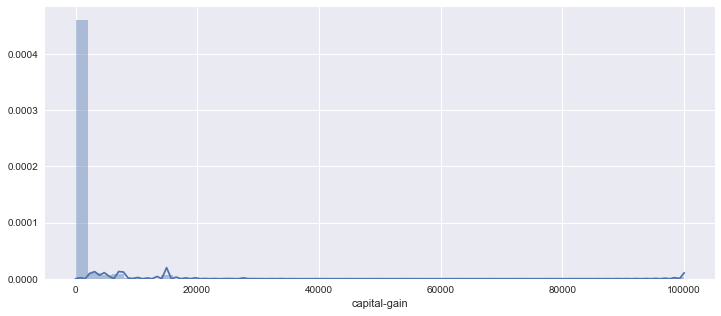

In [60]:
# Weird... Let's plot
# Lets take a look of the fnlwgt distribution
plt.figure(figsize=(12,5))
sns.distplot(df['capital-gain'], kde=True)

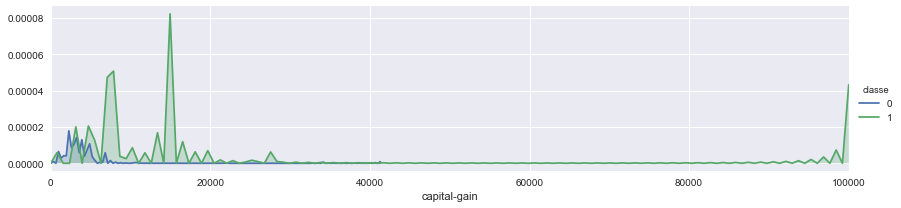

In [61]:
facet = sns.FacetGrid(df, hue="classe",aspect=4)
facet.map(sns.kdeplot,'capital-gain',shade= True)
facet.set(xlim=(0, df['capital-gain'].max()))
facet.add_legend()

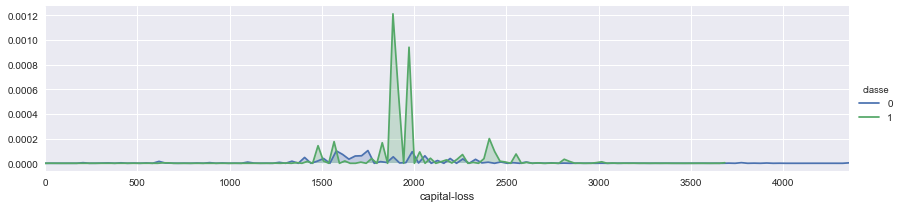

In [62]:
# Lets take a look at capital loss
facet = sns.FacetGrid(df, hue="classe",aspect=4)
facet.map(sns.kdeplot,'capital-loss',shade= True)
facet.set(xlim=(0, df['capital-loss'].max()))
facet.add_legend()

In [64]:
# I'll take a look into these two features latter on
# Lets see some other important features and then make some feature engineering to create a model
df['native-country'].value_counts()

United-States                 43832
Mexico                          951
?                               857
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Nicaragua                        49
Greece                           49
Peru                        

In [65]:
# native country will only add noise to model, so i'll take it off
df.drop('native-country', inplace=True, axis=1)

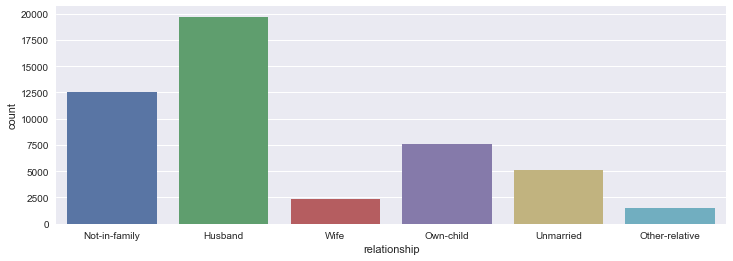

In [66]:
plt.figure(figsize=(12,4))
sns.countplot(x='relationship', data=df)

In [67]:
# Husbands without wifes? Huh?, Ok, lets see how relationships impact the target
avg_relationship = df[['relationship','classe']].groupby('relationship', as_index=False).mean().sort_values(by='classe', ascending=True)

In [68]:
data = [go.Bar(x=avg_relationship['relationship'],
              y=avg_relationship['classe'])]
layout = go.Layout(title='Relationship Mean >50k$ Distribution')
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='EmbDist')

In [69]:
# Ok lets create a feature called husbandOrWife as these two categorys have a higher chance to earn more than 50k
df['husbandOrWife'] = df['relationship'].apply(lambda x: 1 if x in ['Husband','Wife'] else 0)

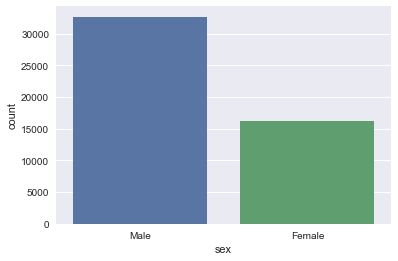

In [70]:
# Does sex have any impact?
sns.countplot(x='sex',data=df)

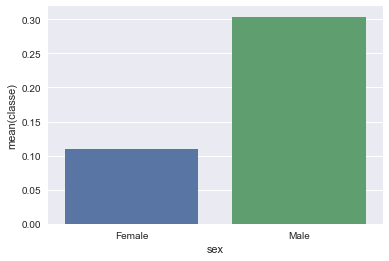

In [71]:
avg_sex = df[['sex','classe']].groupby('sex', as_index=False).mean().sort_values(by='classe', ascending=True)
sns.barplot(x='sex',y='classe',data=avg_sex)

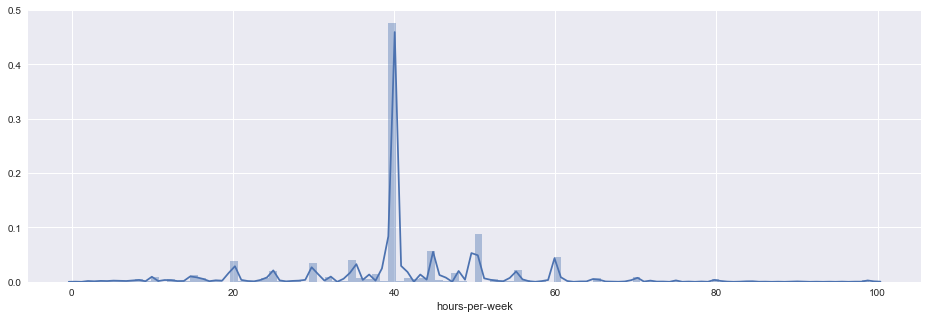

In [81]:
# Since this feature is level 2 i'll leave it like this to feed to a Label Encoder latter
# lets take a look on Hours Per Week
plt.figure(figsize=(16,5))
sns.distplot(df['hours-per-week'], bins=100)

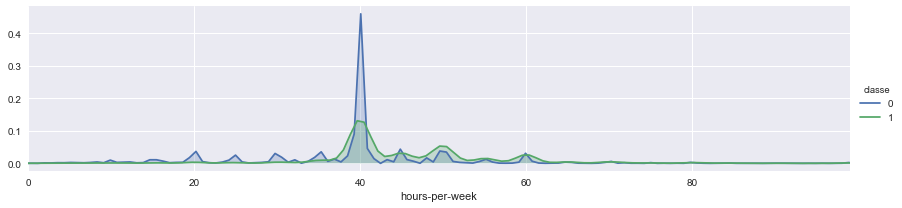

In [82]:
facet = sns.FacetGrid(data=df,hue='classe', aspect=4)
facet.map(sns.kdeplot,'hours-per-week',shade= True)
facet.set(xlim=(0, df['hours-per-week'].max()))
facet.add_legend()

In [83]:
# I'll see if some feature engineering can be helpful in this case
# Now Lets encode the features since many models can't work with strings
# Lets start droping education since we already have this feature encoded (education-num)
df.drop('education', inplace=True, axis=1)

In [85]:
string_cat = 'marital-status occupation relationship race sex workclass'
cat_features = string_cat.split(' ')
cat_features

['marital-status', 'occupation', 'relationship', 'race', 'sex', 'workclass']

In [87]:
df.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,classe,husbandOrWife
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,0,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,0,1
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,0,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,0,1
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,0,1


In [88]:
for ft in cat_features:
    le = LabelEncoder()
    df[ft] = le.fit_transform(df[ft])

In [89]:
df.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,classe,husbandOrWife
0,39,7,77516,13,4,1,1,4,1,2174,0,40,0,0
1,50,6,83311,13,2,4,0,4,1,0,0,13,0,1
2,38,4,215646,9,0,6,1,4,1,0,0,40,0,0
3,53,4,234721,7,2,6,0,2,1,0,0,40,0,1
4,28,4,338409,13,2,10,5,2,0,0,0,40,0,1


In [90]:
rf = RandomForestClassifier(n_estimators=1000)

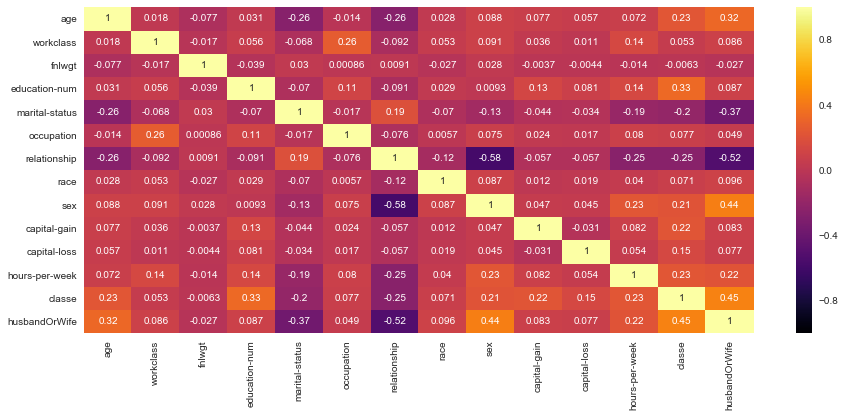

In [92]:
plt.figure(figsize=(15,6))
sns.heatmap(df.corr(), cmap='inferno', annot=True)

In [94]:
# Its more accurate than train_test_split as it tests in 10 folds... but it takes sooo long and is not so different
# in this case
#accuracy = cross_val_score(estimator=rf, X=df.drop(labels=['classe','relationship'],axis=1), y=df['classe'], cv=10, scoring='accuracy')

In [95]:
#print(accuracy.mean())
#print(accuracy.std())

0.858809989077
0.00352690314816


In [116]:
X = df.drop(labels=['classe','relationship', 'marital-status', 'race', 'sex'],axis=1)
y = df['classe']

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [118]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [119]:
predictions = rf.predict(X_test)

In [120]:
print(confusion_matrix(predictions, y_test))
print(classification_report(predictions, y_test))

[[11365  1481]
 [  839  2433]]
             precision    recall  f1-score   support

          0       0.93      0.88      0.91     12846
          1       0.62      0.74      0.68      3272

avg / total       0.87      0.86      0.86     16118



In [123]:
for feat,importance in zip(X.columns, list(rf.feature_importances_)):
    print('Feature: ', feat, 'Importance: ', importance)
    #print('Feature: {}  Importance: {}'.format(feat, importance))

Feature:  age Importance:  0.156778078776
Feature:  workclass Importance:  0.0402737058992
Feature:  fnlwgt Importance:  0.203684746149
Feature:  education-num Importance:  0.119049104035
Feature:  occupation Importance:  0.066404845686
Feature:  capital-gain Importance:  0.124569788427
Feature:  capital-loss Importance:  0.0413897942942
Feature:  hours-per-week Importance:  0.0827223331069
Feature:  husbandOrWife Importance:  0.165127603628


In [ ]:
# I'll make some feature engineering to get at leats 90%
# Scenes for next chapters